In [1]:
import os
from tqdm import tnrange, tqdm_notebook, tqdm
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torchvision.utils import save_image, make_grid
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter

In [2]:
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [3]:
from matplotlib import rcParams
rcParams['figure.figsize'] = (12, 8)

%matplotlib inline

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
torch.cuda.is_available()

True

In [6]:
device_ids = [0]

In [7]:
batch_size = 128
num_epochs = 100

z_dimension = 100

img_shape = (1, 32, 32)

In [8]:
img_transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5), (.5, .5, .5))
])

dataset = datasets.MNIST('/home/left5/datas/mnist', transform=img_transform) #, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [9]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.label_embedding = nn.Embedding(10, 10)

        self.model = nn.Sequential(
            nn.Linear(10 + int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1)
        )

    def forward(self, img, labels):
        # Concatenate label embedding and image to produce input
        d_in = torch.cat((img.view(img.size(0), -1), self.label_embedding(labels)), -1)
        validity = self.model(d_in)
        return validity

In [10]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(10, 10)

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(z_dimension + 10, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # Concatenate label embedding and image to produce input
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        img = self.model(gen_input)
        img = img.view(img.size(0), *img_shape)
        return img

In [23]:
D = Discriminator().to(device)
G = Generator().to(device)

D = nn.DataParallel(D, device_ids=device_ids).to(device)
G = nn.DataParallel(G, device_ids=device_ids).to(device)

adversarial_loss = nn.MSELoss()

D_optimezer = optim.Adam(D.parameters(), lr=2e-4, betas=(0, 0.9))
G_optimezer = optim.Adam(G.parameters(), lr=2e-4, betas=(0, 0.9))

In [12]:
condition = torch.from_numpy(np.arange(10)).cuda()

In [13]:
writer = SummaryWriter('./log/cgan')

In [14]:
img_path = "save_images/cgan"
if not os.path.exists(img_path): os.makedirs(img_path)

In [15]:
total_count = len(dataloader)
for epoch in tqdm_notebook(range(num_epochs)):
    _step = epoch * total_count
    
    d_loss_total = .0
    g_loss_total = .0
    for i, (imgs, labels) in enumerate(dataloader):
        
        real_imgs = imgs.cuda()
        real_labels = labels.float().cuda()
        
        real = torch.ones(imgs.size(0), 1).cuda()
        fake = torch.zeros(imgs.size(0), 1).cuda()
        
        z = torch.randn(imgs.size(0), z_dimension).cuda()
        fake_labels = torch.from_numpy(np.random.randint(0, 10, imgs.size(0))).cuda()
        
        ########## G ##########
        fake_imgs = G(z, fake_labels)
        fake_out = D(fake_imgs, fake_labels)
        g_loss = adversarial_loss(fake_out, real)
        
        G_optimezer.zero_grad()
        g_loss.backward()
        G_optimezer.step()
        #######################
        
        ########## D ##########
        real_out = D(real_imgs, labels)
        d_loss_real = adversarial_loss(real_out, real_labels)
        real_scores = real_out
        
        fake_out = D(fake_imgs.detach(), fake_labels)
        d_loss_fake = adversarial_loss(fake_out, fake)
        fake_scores = fake_out
        
        d_loss = (d_loss_real + d_loss_fake) / 2
        D_optimezer.zero_grad()
        d_loss.backward()
        D_optimezer.step()
        #######################
        
        d_loss_total += d_loss.item() * imgs.size(0)
        g_loss_total += g_loss.item() * imgs.size(0)
        
        step = _step + i + 1
        
        if (i + 1) % 100 == 0:
            writer.add_scalar('Discriminator Real Loss', d_loss_real.item(), step)
            writer.add_scalar('Discriminator Fake Loss', d_loss_fake.item(), step)
            writer.add_scalar('Discriminator Loss', d_loss.item(), step)
            writer.add_scalar('Generator Loss', g_loss.item(), step)
        
        if (i + 1) % 300 == 0:
            tqdm.write('Epoch [{}/{}], Step: {:6d}, d_loss: {:.6f}, g_loss: {:.6f}, real_scores: {:.6f}' \
', fake_scores: {:.6f}'.format(epoch+1, num_epochs, (i+1) * batch_size, d_loss, g_loss, real_scores.mean(), fake_scores.mean()))
    
    setp = (epoch + 1) * total_count
    _d_loss_total = d_loss_total / (total_count * (epoch + 1))
    _g_loss_total = g_loss_total / (total_count * (epoch + 1))
    
    writer.add_scalar('Discriminator Total Loss', _d_loss_total, step)
    writer.add_scalar('Generator Total Loss', _g_loss_total, step)
    
    tqdm.write("Finish Epoch [{}/{}], D Loss: {:.6f}, G Loss: {:.6f}".format(epoch+1, 
                                                                             num_epochs, 
                                                                             _d_loss_total,
                                                                             _g_loss_total, ))
    
    if epoch == 0:
        real_images = real_imgs.view(-1, 1, 32, 32).cpu().data
        save_image(real_images, os.path.join(img_path, 'real_images.png'))
        
    noise = torch.randn(10, z_dimension).cuda()
    condition_images = G(noise, condition)
    
    writer.add_image('Generator Image', make_grid(fake_imgs.view(-1, 1, 32, 32).cpu().data, normalize=True, scale_each=True), step)
    writer.add_image('Condition Generator Image', make_grid(condition_images.view(-1, 1, 32, 32).cpu().data, normalize=True, scale_each=True), step)
    
    fake_images = fake_imgs.view(-1, 1, 32, 32).cpu().data
    save_image(fake_images, os.path.join(img_path, 'fake_images-{}.png'.format(epoch+1)))
    save_image(condition_images, os.path.join(img_path, 'condition_images-{}.png'.format(epoch+1)))

Epoch [1/100], Step:  38400, d_loss: 5.021608, g_loss: 0.670274, real_scores: 3.313416, fake_scores: 0.195969
Finish Epoch [1/100], D Loss: 672.395041, G Loss: 51.382040
Epoch [2/100], Step:  38400, d_loss: 4.790895, g_loss: 0.065153, real_scores: 4.175670, fake_scores: 1.029709
Finish Epoch [2/100], D Loss: 342.620750, G Loss: 39.549698
Epoch [3/100], Step:  38400, d_loss: 4.362248, g_loss: 1.007721, real_scores: 3.595812, fake_scores: 0.067716
Finish Epoch [3/100], D Loss: 226.324900, G Loss: 33.955324
Epoch [4/100], Step:  38400, d_loss: 6.970471, g_loss: 1.279209, real_scores: 5.280122, fake_scores: 1.892786
Finish Epoch [4/100], D Loss: 165.611778, G Loss: 27.759672
Epoch [5/100], Step:  38400, d_loss: 4.637150, g_loss: 0.890376, real_scores: 4.299845, fake_scores: 0.224829
Finish Epoch [5/100], D Loss: 132.797144, G Loss: 21.267767
Epoch [6/100], Step:  38400, d_loss: 4.214018, g_loss: 0.371517, real_scores: 4.159974, fake_scores: 0.589710
Finish Epoch [6/100], D Loss: 108.183142

Finish Epoch [49/100], D Loss: 14.314531, G Loss: 2.573712
Epoch [50/100], Step:  38400, d_loss: 5.808828, g_loss: 1.517761, real_scores: 3.245606, fake_scores: 0.038120
Finish Epoch [50/100], D Loss: 14.019360, G Loss: 2.504284
Epoch [51/100], Step:  38400, d_loss: 5.199376, g_loss: 1.629941, real_scores: 3.374518, fake_scores: 0.093399
Finish Epoch [51/100], D Loss: 13.763196, G Loss: 2.522712
Epoch [52/100], Step:  38400, d_loss: 5.076087, g_loss: 0.825231, real_scores: 4.235047, fake_scores: 0.759261
Finish Epoch [52/100], D Loss: 13.515750, G Loss: 2.414828
Epoch [53/100], Step:  38400, d_loss: 5.735970, g_loss: 0.801699, real_scores: 4.104893, fake_scores: 0.933107
Finish Epoch [53/100], D Loss: 13.199323, G Loss: 2.415310
Epoch [54/100], Step:  38400, d_loss: 5.281273, g_loss: 0.891698, real_scores: 3.876538, fake_scores: 0.590293
Finish Epoch [54/100], D Loss: 13.015031, G Loss: 2.407670
Epoch [55/100], Step:  38400, d_loss: 6.839543, g_loss: 2.438994, real_scores: 2.625900, fa

Epoch [98/100], Step:  38400, d_loss: 5.391006, g_loss: 0.733787, real_scores: 3.857824, fake_scores: 0.510969
Finish Epoch [98/100], D Loss: 7.090047, G Loss: 1.277989
Epoch [99/100], Step:  38400, d_loss: 5.576273, g_loss: 0.820182, real_scores: 4.027280, fake_scores: 0.242472
Finish Epoch [99/100], D Loss: 6.985028, G Loss: 1.239300
Epoch [100/100], Step:  38400, d_loss: 5.243590, g_loss: 0.840767, real_scores: 4.021846, fake_scores: 0.735124
Finish Epoch [100/100], D Loss: 6.894644, G Loss: 1.272844



In [16]:
writer.close()

In [24]:
# torch.save(D.state_dict(), './ser/cgan_discriminator.pkl')
# torch.save(G.state_dict(), './ser/cgan_generator.pkl')
torch.save(D, './ser/cgan_discriminator.pt')
torch.save(G, './ser/cgan_generator.pt')

In [30]:
# D.load_state_dict(torch.load('./ser/cgan_discriminator.pkl'))
# G.load_state_dict(torch.load('./ser/cgan_generator.pkl'))
# D.eval()
# G.eval()

D = torch.load('./ser/cgan_discriminator.pt')
G = torch.load('./ser/cgan_generator.pt')

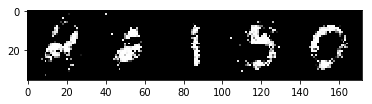

In [37]:
l = torch.from_numpy(np.array([2,6,1,3,0])).cuda()
z = torch.randn(5, z_dimension).to(device)
images = G(z, l)
# save_image(images, 'xx.png')
plt.imshow(Image.fromarray(make_grid(images).mul(255).clamp(0, 255).byte().permute(1, 2, 0).cpu().numpy()))
plt.show()